## Monte Carlo simulations of the Nagel-Schreckenberg traffic model

References:

    [1] https://arxiv.org/pdf/cond-mat/9902170
    [2] https://doi.org/10.1016/0378-4371(95)00442-4
    [3] https://doi.org/10.1103/PhysRevE.51.2939
    [4] https://en.wikipedia.org/wiki/Fundamental_diagram_of_traffic_flow

In this model, we have a single-lane road with periodic boundary conditions (a circular road, the number of cars is conserved). The road is divided into $M$ different positions, whose states can be either empty or occupied by one car only, and there are $k$ cars on the road, being $k < M$.    

Firstly, let's define a function that runs the simulation for a given set of parameters:
* _M_: number of positions on the road, takes integer values
* _N_: total number of timesteps to run, takes integer values
* _V_max_: maximum velocity allowed, takes integer values
* _k_: number of cars, takes integer values, _k <= M_
* _p_: probability of random braking, takes integer values, _p>=1_. It has to be interpreted in this way: p is the parameter of the function, representing that there is a 1/p probability of breaking during the iteration
* _semilla_: to keep track of the random number generator's seed.

This function will return a numpy.array of _k_ lists, one for each car on the road, and each list will contain the position of the car for every timestep: 

In [9]:
import numpy as np
from random import seed, randint

def Trafic(M, N, V_max, k, p, semilla) -> np.array:
    """
    Parameters:
        M: number of positions on the road
        N: total number of timesteps
        V_max: maximum velocity
        k: number of cars
        p: probability of random braking (1/p)
        semilla: seed for the random gen.
   """ 
    seed(semilla)
    
    #Set-up inicial - autos equiespaciados excepto el primero y el último, en reposo 
    X=np.linspace(0,M-1,k,dtype=int)
    V=np.zeros(k)
    
    #Burn-in: 100 steps
    N1=100                              # Hago N1 interaciones
    for paso in range(N1):              
        for i in range(k):              # Cambio la vel. de cada auto:
            if V[i]<V_max:              # Primero aumento la velocidad
                V[i]=V[i]+1             
    
            d=(X[(i+1)%k]-X[i])%M       # Calculo la dist. al auto de adelante,
                                        # con las cond. de contorno periodicas.
            if V[i]>=d:                 # Ahora me fijo si al aumentar la vel.,
                V[i]=d-1                # hay choque con el de adelante, si hay
                                        # choque, disminuyo la vel.
                                        
            if p!=0:                    # Introduzco aleatoriedad si p!=0                                         
                frena=randint(1,p)      # Tiro un número entre 1 y p con distr.
                                        # normal.
                if frena==p:            # Si sale p, disminuyo la vel.
                    V[i]=max(V[i]-1,0)
    
        for i in range(k):              # Guardo las nuevas posiciones
            X[i]=(X[i]+V[i])%M
    
    #The real simulation: N timesteps
    Pos=np.zeros((N,X.size))
    j=0
    for paso in range(N):
        for i in range(k):
            if V[i]<V_max:
                V[i]=V[i]+1
    
            d=(X[(i+1)%k]-X[i])%M
            if V[i]>=d:
                V[i]=d-1
    
            if p!=0:
                frena=randint(1,p)
                if frena==p:
                    V[i]=max(V[i]-1,0)
    
        for i in range(k):
            X[i]=(X[i]+V[i])%M
    
        # Guardo las posiciones
        Pos[j,:]=X
        j+=1
    
    return Pos

In the following sections, the fundamental diagram is calculated for $V_{max} = 1, 3, 5$, studying its functional form for various values of the braking probability _p_. The fundamental diagram of traffic flow, as defined in [4], requires plotting the traffic flow vs the traffic density. In this work, these are calculated as follows:
* $Density = \dfrac{Cars}{Length} = \dfrac{k}{M}$ 
* $Flow = Velocity \cdot Density = \dfrac{Distance}{M.N}$

Hence, the total distance traveled by all the cars is to be calculated, for a given number of cars on the road.

### **1) Without random braking: p=0**

When p=0, the flow is deterministic, since all the cars will only try to accelerate at each timestep. For a low density of cars, eventually, there will be enough empty positions ahead for every car to reach its maximum velocity, and so the stationary state will be the one with all the cars moving with $V_{i}=V_{max}$. As stated in [1], the fundamental diagram is given by

$$f(c) = \begin{cases} V_{max} \cdot c & \,,\, c \leq \frac{1}{V_{max}+1} \\ 1-c & \,,\, c > \frac{1}{V_{max}+1} \end{cases}$$

where _c_ is the traffic density, and _flow = f(c)_.

**Fundamental diagram for** **$V_{max} = 1,3,5$**

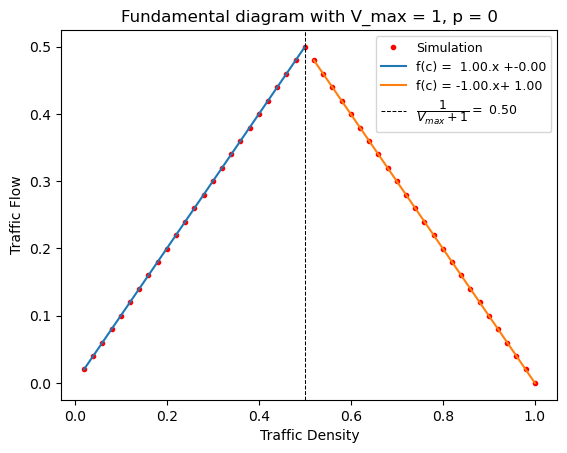

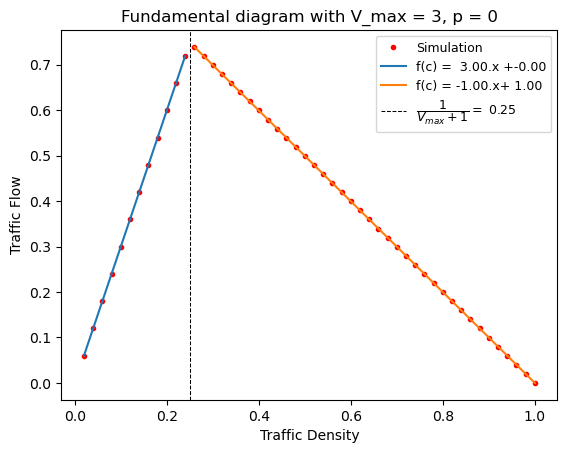

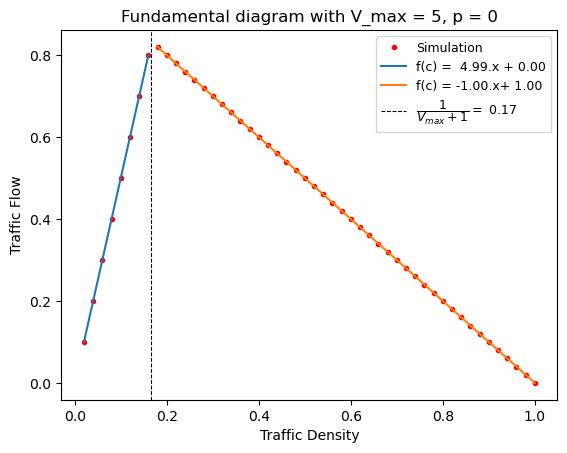

In [13]:
from matplotlib import pyplot as plt
from os import urandom
from scipy.optimize import curve_fit
import numpy as np

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for velocidad in [1,3,5]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=velocidad
    
    # Diagrama fundamental con autos entre 20 y 1000, p=0:
    Distancias_totales = []      # La distancia total en cada simulación
    for autos in np.arange(20,1020,20):
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, 0, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para esa V_max:
    densidad = np.arange(20,1020,20)/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Separo los valores según regimen de densidades cortando en 1/(V_max +1): 
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []
    for i, j in zip(densidad, flujo):
        if i <= 1/(V_max+1):
            x_1.append(i)
            y_1.append(j)
        elif i >= 1/(V_max+1):
            x_2.append(i)
            y_2.append(j)
    
    # Defino una función lineal para ajustar.
    def F(x, a, b):
        return a*x + b
            
    # Ahora hago los ajustes lineales en cada uno y grafico:
    param_1, covar_1 = curve_fit(F, x_1, y_1)
    param_2, covar_2 = curve_fit(F, x_2, y_2)
    
    densidad_1 = np.linspace(min(x_1), max(x_1),100)
    densidad_2 = np.linspace(min(x_2), max(x_2),100)
    
    fig, ax = plt.subplots()
    ax.plot(densidad, flujo, 'r.', label = "Simulation")
    ax.plot(densidad_1, F(densidad_1, param_1[0], param_1[1]), label = f"f(c) = {param_1[0]: .2f}.x"
            f" +{param_1[1]: .2f}")
    ax.plot(densidad_2, F(densidad_2, param_2[0], param_2[1]), label = f"f(c) = {param_2[0]: .2f}.x"
            f"+{param_2[1]: .2f}")
    
    # Ubico el punto de corte según 1/(V_max+1)
    ax.axvline(1/(V_max+1), linewidth=0.75, linestyle="dashed", color='black', 
           label=r"$\dfrac{1}{V_{max}+1} = $"f"{1/(V_max+1): .2f}")
    
    ax.set_xlabel("Traffic Density")
    ax.set_ylabel("Traffic Flow")
    ax.set_title("Fundamental diagram with V_max = {}, p = {}".format(V_max, 0))
    ax.legend(loc="upper right", fontsize=9)

### **2) With p=2: 50% chances of random braking**

When $0<P<1$, there is no analytical solution known for this traffic model. The authors in [3] proposed an approximation to the solution based on mean-field theory considerations. In this work we present the results of the simulations for some values of $V_{max}$.  

**Fundamental diagram for $V_{max}=1,2,3$**

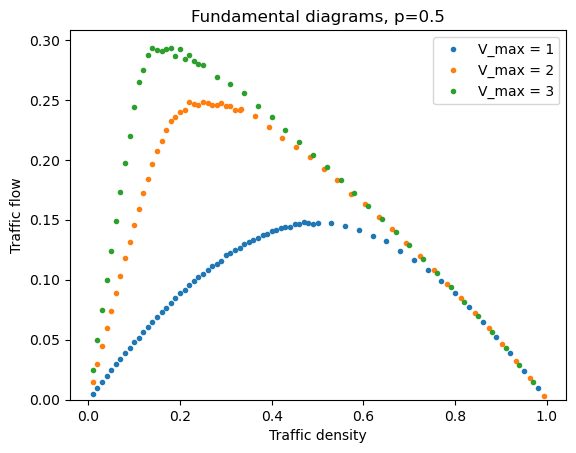

In [20]:
from matplotlib import pyplot as plt
from os import urandom
import numpy as np

Diagramas=[]     # Acá guardo los diagramas por cada velocidad:
                 # [[flujo_1, densidad_1], [flujo_2, densidad_2], ...]

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for velocidad in [1,2,3]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=velocidad
    
    # Diagrama fundamental con autos entre 20 y 1000, p=2:
    Distancias_totales = []      # La distancia total en cada simulación
    autos_totales = np.concatenate((np.arange(10,largo//(V_max+1),10),
                                    np.arange(largo//(V_max+1),1000,30)))
    for autos in autos_totales:
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, 2, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para esa V_max:
    densidad = autos_totales/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Los guardo el Diagramas:
    Diagramas.append([flujo, densidad])
    
# Y ahora grafico todo en un mismo plot:    
    
velocidad=1
for datos in Diagramas:
    plt.plot(datos[1], datos[0], '.', label="V_max = {}".format(velocidad)) 
    #plt.vlines(1/(velocidad+1),ymin=0, ymax= max(datos[0]), linewidth=0.75, 
    #            linestyles="dashed", colors='black')
    
    velocidad += 1 
    
plt.ylim(0)    
plt.xlabel("Traffic density")
plt.ylabel("Traffic flow")
plt.title("Fundamental diagrams, p=0.5")
plt.legend(loc="upper right", fontsize=10)   
plt.show()